<a href="https://colab.research.google.com/github/OleksiiLatypov/Practical_Deep_Learning_with_PyTorch/blob/main/test_template_char_level_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music generation with a Character-level Recurrent Neural Network

Hi, and welcome! In this lab, we will get creative and learn how to generate songs in the style of Chopin. Let's the show begin!

**GPU** is recomended for this assignment. `Runtime` -> `Change runtime type` -> `GPU`

**Instructions**
- Write code in the space indicated with `### START CODE HERE ###`
- Do not use loops (for/while) unless instructions explicitly tell you so. Parallelization in Deep Learning is key!
- If you get stuck, ask for help in Slack or DM `@DRU Team`

**You will learn**
- How to build an image segmentation algorithm
    - How to preprocess midi files
    - How to build an LSTM model
    - How to sample from a trained model

# 0 - Set up the environment
We recommend that you use Google Colab for this lab. However, if you are running this lab on an OS without `apt-get`, you can use [Homebrew](https://brew.sh/) on macOS (or Linux) or [Chocolatey](https://chocolatey.org/) on Windows to install `lilypond` and `fluidsynth`. In any case, those two packages are not required for completing this lab. We will use them to display sheet music and play it in Jupyter.

In [175]:
# install music21
!pip install music21

# enables music21 to render images of musical notes
print('installing lilypond...')
!apt-get install lilypond > /dev/null

# converts midi files to wav files into order to play them
print('installing fluidsynth...')
!apt-get install fluidsynth > /dev/null
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

print('done!')
!fluidsynth --version
!lilypond --version

installing lilypond...
installing fluidsynth...
done!
FluidSynth runtime version 2.2.5
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

FluidSynth executable version 2.2.5
Sample type=double
GNU LilyPond 2.22.1

Copyright (c) 1996--2021 by
  Han-Wen Nienhuys <hanwen@xs4all.nl>
  Jan Nieuwenhuizen <janneke@gnu.org>
  and others.

This program is free software.  It is covered by the GNU General Public
License and you are welcome to change it and/or distribute copies of it
under certain conditions.  Invoke as `lilypond --warranty' for more
information.



In [176]:
def play(music):
    """plays music in Jupyter"""
    music.write('midi', fp='temp.mid')
    !fluidsynth -ni font.sf2 temp.mid -F temp.wav -r 16000 > /dev/null
    display(Audio('temp.wav'))

def show(music):
    """shows music sheet"""
    display(Image(str(music.write('lily.png'))))

## Download data

In [177]:
!pip install wget
import wget
wget.download('https://dru.fra1.digitaloceanspaces.com/DL_pytorch/static/4_recurrent_nn/char_level_rnn/template.zip')
!unzip -q template.zip

replace Chopin/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
replace Chopin/chopin_Nocturne_b49.mid? [y]es, [n]o, [A]ll, [N]one, [r]ename: [y]
error:  invalid response [[y]]
replace Chopin/chopin_Nocturne_b49.mid? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Chopin/chopin_op55_1.mid? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
replace Chopin/Nocturne_Opus_72_No_1_in_E_Minor.mid? [y]es, [n]o, [A]ll, [N]one, [r]ename: No


# 1 - Import packages

In this lab, we will use [music21](https://web.mit.edu/music21/) library, for parsing and creating `.midi` files.

In [178]:
import torch
from torch import nn
from torch import optim

import os, shutil
from tqdm.auto import tqdm
import random
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from music21 import converter, instrument, stream, note, chord
from IPython.display import Image, Audio

%matplotlib inline

## Config

In [201]:
# VALIDATION_FIELD[cls] Config

class Config:
    # data
    dataroot = './Chopin'
    # model
    vocab_size = 284
    seq_len = 64
    num_layers = 3
    hidden_size = 512
    embedding_size = 512
    dropout = 0.25
    # training
    seed = 21
    batch_size = 8
    learning_rate = 0.001
    epochs = 500
    save_every = 50
    clip = 5
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [202]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(Config.seed)

# 2 - Data exploration and preprocessing

## Preprocess Midi Files
Here we will define a function `parse_midi` to convert a midi file to a list of notes and chords. Next, we will run this function over a dataset of 8 Chopin works taken from [Classical Music Midi dataset](https://www.kaggle.com/soumikrakshit/classical-music-midi) from Kaggle.

In [203]:
def parse_midi(file):
    note_list = []
    music = converter.parse(file)
    # Handle cases for multi-instruments
    try:
        parts = instrument.partitionByInstrument(file)
        notes = parts.parts[0].recurse()
    except:
        notes = music.flatten().notes

    # Handle chords
    for singleNote in notes:
        if isinstance(singleNote, chord.Chord):
            note_list.append('.'.join(str(norm) for norm in singleNote.normalOrder))
        elif isinstance(singleNote, note.Note):
            note_list.append(str(singleNote.pitch))
    return note_list

In [204]:
songs = []
for midi_file in os.listdir(Config.dataroot):
    if midi_file.endswith('.mid'):
        notes = parse_midi(os.path.join(Config.dataroot, midi_file))
        songs.append(notes)

## Understanding the data

Our dataset consists of **8** songs, each has a different length (maximal length of a song is **1378**, and the minimum length is **144**). Each song is a list of notes or chords. In the example below, chords are `'5.8.0'`, `'10.3'`, while individual notes are `'C5'`, `'F2'`, `'F5'`, `'E-5'`, etc. Our **task** will be to build **many-to-many** RNN that will make predictions about the next note in the sequence.

In [205]:
print(f'Total of {len(songs)} songs')
print('Length of each song:', [len(song) for song in songs])
print('First 10 tokens of a third song:', songs[1][:10])

Total of 8 songs
Length of each song: [1008, 1266, 599, 143, 665, 878, 1577, 1087]
First 10 tokens of a third song: ['B-5', 'C6', 'C#6', 'A5', 'B-5', 'F#5', '5.10', 'F3', '1.5', 'B-3']


## All notes

To simplify the learning objective, we will combine all tracks into one long sequence, `all_notes`. This will allow us to train our model continuously without reinitializing the hidden state of the recurrent neural network.

In [206]:
all_notes = np.array([note for s in songs for note in s])

## Collect all unique tokens

The common preprocessing step in building an RNN is to transform input tokens into numeric indices. So, let's define dictionaries that convert notes(and chords) to indices and indices to notes.

**Excercise** implement `get_mappings` function that takes `all_notes` as input, and returns two mapping dictionaries `note2idx` and `idx2note`.

In [207]:
def get_mappings(notes):
    """
    Create dictionaries mapping notes to their indices and vice versa.

    Args:
        notes: A list of unique notes.

    Returns:
        note2idx: A dictionary mapping notes to their indices.
        idx2note: A dictionary mapping indices to notes.
    """

    unique_notes = np.unique(notes)  # Get unique notes
    note2idx = {note: i for i, note in enumerate(unique_notes)}  # Map note to index
    idx2note = {i: note for i, note in enumerate(unique_notes)}  # Map index to note

    return note2idx, idx2note


In [208]:
notes_example = np.array(['C5', 'F2', 'F5', '5.8.0', 'E-5', 'G2', 'C#5', '10.3', 'F5', 'G#2', 'C5'])
note2idx, idx2note = get_mappings(notes_example)
print('Note to index mapping:', note2idx)
print('Index to note mapping:', idx2note)

Note to index mapping: {'10.3': 0, '5.8.0': 1, 'C#5': 2, 'C5': 3, 'E-5': 4, 'F2': 5, 'F5': 6, 'G#2': 7, 'G2': 8}
Index to note mapping: {0: '10.3', 1: '5.8.0', 2: 'C#5', 3: 'C5', 4: 'E-5', 5: 'F2', 6: 'F5', 7: 'G#2', 8: 'G2'}


**Expected output:**
    
<table>
    <tr>
        <td><b>Note to index</b></td>
        <td>{'10.3': 0, '5.8.0': 1, 'C#5': 2, 'C5': 3, 'E-5': 4, 'F2': 5, 'F5': 6, 'G#2': 7, 'G2': 8}
        </td>
    </tr>
    <tr>
        <td><b>Index to note</b></td>
        <td>{0: '10.3', 1: '5.8.0', 2: 'C#5', 3: 'C5', 4: 'E-5', 5: 'F2', 6: 'F5', 7: 'G#2', 8: 'G2'}
        </td>
    </tr>

</table>

In [189]:
# apply idx transformation on notes
note2idx, idx2note = get_mappings(all_notes)
all_notes = np.array([note2idx[note] for note in all_notes])

## Generate music from an array

Next, we will define a function that will generate a music stream out of a NumPy array. We will use `lilypond` and `fluidsynth` to see and listen to the music.

In [209]:
def array_to_music(array):
    offset = 0
    midiOutput = []
    for notePat in array:
        # It is a chord.
        if ('.' in notePat) or notePat.isdigit():
            # Split to notes
            notes_in_chord = notePat.split('.')
            notes = []

            # chord as notes
            for eachNote in notes_in_chord:
                new_note = note.Note(int(eachNote))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)

            # Convert to midi chord and store
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            midiOutput.append(new_chord)
        # pattern is a note
        else:
            # Convert to midi note and store
            new_note = note.Note(notePat)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            midiOutput.append(new_note)
        # increase offset to make sure notes do not stack
        offset += 0.5
    # Convert to midi stream
    music = stream.Stream(midiOutput)
    return music

In [210]:
notes = [idx2note[idx] for idx in all_notes[:250]] # first 250 notes
music = array_to_music(notes)
play(music)
show(music)

KeyError: 'C5'

## Create batching for our stream of notes

Unfortunately, we cannot simply fit all `8177` notes into our model at once. This will be computationally inefficient, and our computation graph will probably be too big for the model to learn anything useful. To resolve these problems, we will do the following:

* Split our notes into `batch_size` number of songs and feed them in parallel.
* Feed only `seq_length` notes at once, and then reset our computation graph.

Therefore, we want our data loader to return a tensor of shape `(batch_size, seq_length)` at every iteration. However, we don't want to reinitialize the hidden state between the batches (we will only detach it from the computation graph), so we need our data loader to generate sequential batches of notes. For example, if the **0th** sample in the first batch was `[1, 2, 3, 4, 5]` (`seq_len = 5`), we want the **0th** sample in the next batch to be `[6, 7, 8, 9, 10]`. In this case, the hidden state from the first batch will be relevant for the second batch.

**Excercise:** Implement `get_dataloader` to perform batching on the given `arr` of tokens, as shown on the diagram below:

<img src="https://dru.fra1.digitaloceanspaces.com/DL_pytorch/static/ntbk_images/batching.png">

**Hints:**
* Discard notes if the input array is not divisible by `batch_size`
* Output X and Y should have the shape of (batch_size, seq_length)
* Your function should return a generator; it should `yield` the resulting batches

In [199]:
import numpy as np

def get_dataloader(arr, batch_size=Config.batch_size, seq_length=Config.seq_len):
    """
    Create a generator that returns batches of size
    (batch_size, seq_length) from arr.
    """
    #arr = np.array(arr)
    # total_length = len(arr)
    # #num_full_sequences = (total_length - 1) // seq_length
    # num_full_sequences = (total_length) // seq_length
    # sequences_per_batch = num_full_sequences // batch_size

    # for i in range(sequences_per_batch):
    #     x = np.zeros((batch_size, seq_length), dtype=np.int32)
    #     y = np.zeros((batch_size, seq_length), dtype=np.int32)

    #     for j in range(batch_size):
    #         start_idx = (i * seq_length) + (j * sequences_per_batch * seq_length)
    #         end_idx = start_idx + seq_length
    #         x[j] = arr[start_idx:end_idx]
    #         y[j] = arr[start_idx + 1:end_idx + 1]

    #     yield x, y
    total_length = len(arr)
    num_full_sequences = (total_length) // seq_length
    sequences_per_batch = num_full_sequences // batch_size

    for i in range(sequences_per_batch):
        x = np.zeros((batch_size, seq_length), dtype=np.int32)
        y = np.zeros((batch_size, seq_length), dtype=np.int32)

        for j in range(batch_size):
            # start_idx = j * (sequences_per_batch * seq_length) + i * seq_length
            start_idx = i * seq_length + j * (num_full_sequences * seq_length) // batch_size
            end_idx = start_idx + seq_length
            x[j] = arr[start_idx:end_idx]
            y[j] = arr[start_idx + 1:end_idx + 1]

        yield x, y


In [200]:
notes = np.arange(1, 30)
dl = get_dataloader(notes, batch_size=3, seq_length=4)
for idx, (x, y) in enumerate(dl):
    print(f'inputs #{idx}')
    print(x)
    print(f'targets #{idx}')
    print(y)

inputs #0
[[ 1  2  3  4]
 [10 11 12 13]
 [19 20 21 22]]
targets #0
[[ 2  3  4  5]
 [11 12 13 14]
 [20 21 22 23]]
inputs #1
[[ 5  6  7  8]
 [14 15 16 17]
 [23 24 25 26]]
targets #1
[[ 6  7  8  9]
 [15 16 17 18]
 [24 25 26 27]]


**Expected output:**
<table>
<tr>
    <td> <b>input #0</b> </td>
    <td> [[ 1  2  3  4] <br>
          [10 11 12 13] <br>
          [19 20 21 22]]
    </td>
    <td> <b>targets #0</b> </td>
    <td> [[ 2  3  4  5] <br>
 [11 12 13 14]<br>
 [20 21 22 23]]
    </td>
</tr>
<tr>
    <td> <b>input #1</b> </td>
    <td> [[ 5  6  7  8]<br>
 [14 15 16 17]<br>
 [23 24 25 26]]
    </td>
     <td> <b>targets #1</b> </td>
    <td> [[ 6  7  8  9]<br>
 [15 16 17 18]<br>
 [24 25 26 27]]
    </td>
</tr>
</table>

# 3 - Defining Model Class

For this dataset, we will use a stack of several **LSTM** layers and an **Embedding** layer.

<img src="https://dru.fra1.digitaloceanspaces.com/DL_pytorch/static/ntbk_images/stacked_lstm.png">

The **embedding** layer is used to transform an input token into a large vector that will be passed to our **LSTM** model. Basically, **embedding** simply defines a matrix of shape `(num_embeddings, embedding_dim)` as a trainable parameter, where `num_embeddings` is a number of unique notes in our dataset (`vocab_size`), and `embedding_dim` is a size of the output vector. During training, we will select a needed row of the matrix using an input index of a token. For example, if an input token is `16`, we will use `embedding[16]` to extract a vector corresponding to `16`. Next, we will pass the vector forward, calculate the loss, and backpropagate through all trainable parameters (including **embedding** layer)

The **LSTM** or Long Short Term Memory network is one of the most successful RNNs. The whole idea behind LSTMs is that they can learn long-term dependencies using two hidden state vectors $C_t$ and $h_t$ instead of one (in vanilla RNN). The diagram below shows how the calculation works in LSTM:

<img src="https://dru.fra1.digitaloceanspaces.com/DL_pytorch/static/ntbk_images/lstm_cell.png">

To stack two or more LSTM models, we will simply pass the hidden state `h_t` as inputs to the higher LSTM and use the hidden state of the highest LSTM model as our prediction.

**Excercise:** Using documentation for [Embedding layer](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html), and [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) define `self.embedding` and `self.LSTM` in the `__init__` method.
* Use `batch_first=True` for LSTM model

In [195]:
# VALIDATION_FIELD[cls] MelodyLSTM

class MelodyLSTM(nn.Module):
    def __init__(
        self,
        vocab_size=Config.vocab_size,   # number of predicted classes (notes)
        emb_size=Config.embedding_size, # size of the embedding vector
        hidden_size=Config.hidden_size, # size of the vectors in LSTM model
        num_layers=Config.num_layers,   # number of LSTM layers
        drop_prob=Config.dropout        # dropout probability for training
        ):
        super(MelodyLSTM, self).__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size

        ### START CODE HERE ### (≈10 lines of code)
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.lstm = nn.LSTM(emb_size, hidden_size, num_layers, dropout=drop_prob, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(drop_prob)
        ### END CODE HERE ###

    def forward(self, x, hidden):        # x: [batch, seq_len, 1]

        ### START CODE HERE ### (≈5 lines of code)
        # Apply embedding
        x = self.embedding(x)            # x: [batch, seq_len, emb_size]
        x, hidden = self.lstm(x, hidden) # x: [batch, seq_len, hidden_size]
        x = self.dropout(x)
        x = self.fc(x)                   # x: [batch, seq_len, vocab_size]
        x = x.view(-1, self.vocab_size)                   # x: [batch * seq_len, vocab_size]
        ### END CODE HERE ###
        return x, hidden

    def init_hidden(self, batch_size):
        # get first hidden state
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        cell = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return (hidden, cell)

AttributeError: type object 'Config' has no attribute 'vocab_size'

# 4 - Training the model

**Here, we will commit a crime!** For this problem, we will not be using a validation set, and instead, we will simply overfit the train data. This is because music generation is a very difficult task for LSTM. To achieve really good results, we would need to use transformer models or GANs that can truly generate original music. However, in our case, we will sacrifice the originality of generated sample to achieve a decent music sample. In other words, our model will **copy** a lot of fragments from Chopin but will still generate some unique samples.

**Note:** a common step in training LSTM is to `clip` the gradients to prevent exploding gradient problems. To perform gradient clipping use `nn.utils.clip_grad_norm_`

**Excercise:** implement the `train` function



In [125]:
def train(
    model, optimizer, criterion, notes,
    batch_size=Config.batch_size,
    num_epochs=Config.epochs,
    train_loss_min=np.inf,
    save_every=Config.save_every,
    clip=Config.clip,
    device=Config.device
):
    losses = []
    pbar = tqdm(range(num_epochs))
    for e in pbar:
        model.train()
        train_loss = 0.0
        ###################
        # train the model #
        ###################
        # initialize hidden state
        h_0, c_0 = model.init_hidden(batch_size)
        h_0, c_0 = h_0.to(device), c_0.to(device)
        num_steps = 0
        for x, y in get_dataloader(notes, batch_size=batch_size, seq_length=Config.seq_len):
            ### START CODE HERE ### (≈10 lines of code)
            # Convert to torch tensors and pass inputs to device
            x = torch.tensor(x, dtype=torch.long).to(device)
            y = torch.tensor(y, dtype=torch.long).to(device)

            # Check for out-of-range indices
            if x.max().item() >= Config.vocab_size or y.max().item() >= Config.vocab_size:
                print(f'Error: Input indices exceed vocab_size. x.max: {x.max().item()}, y.max: {y.max().item()}')
                continue

            # detach hidden state from the previous iteration
            h_0 = h_0.detach()
            c_0 = c_0.detach()

            # zero the gradients
            optimizer.zero_grad()

            # forward pass
            out, (h_0, c_0) = model(x, (h_0, c_0))

            # compute the loss
            loss = criterion(out, y.view(-1))

            # backward pass
            loss.backward()

            # gradient clipping
            if clip:
                nn.utils.clip_grad_norm_(model.parameters(), clip)

            # update model parameters
            optimizer.step()
            ### END CODE HERE ###

            train_loss += loss.item()
            num_steps += 1

        train_loss = train_loss / num_steps
        losses.append(train_loss)
        pbar.set_description(f'train loss: {train_loss:.5f}')

        # save the model if the training loss has decreased
        if train_loss < train_loss_min:
            torch.save(model.state_dict(), 'LSTM.pt')
            train_loss_min = train_loss

    return losses

In [ ]:
model = MelodyLSTM().to(Config.device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=Config.learning_rate)
criterion = nn.CrossEntropyLoss()
train_loss = train(model, optimizer, criterion, all_notes)

  0%|          | 0/500 [00:00<?, ?it/s]

**Expected Output (after 500 iterations):**
<table>
    <tr>
        <td>
            <b>train loss</b>
        </td>
        <td>0.01062</td>
    </tr>
</table>

# 5 - Inference

In [126]:
# Load the latest model
model.load_state_dict(torch.load('LSTM.pt'))

<All keys matched successfully>

## Top-K sampling

To generate the melody, we will use a Random Top-K Sampling method. The idea behind it is that we will feed our input sequence into the model and then do the following iterative procedure:
1. generate outputs from neural network
2. get top-k predictions from the output
3. randomly choose one note using `np.random.choice`
4. feed chosen note back into the model

**Excercise:** implement `generate_sequence` function.

In [173]:
# VALIDATION_FIELD[func] generate_sequences

def generate_sequence(model, start_sequence, note2idx, idx2note, max_length=64, topk=3, device=Config.device):
    result = []
    model.eval()
    with torch.no_grad():
        h, c = model.init_hidden(1)
        h, c = h.to(device), c.to(device)
        # feed initial sequence
        for note in start_sequence:
            result.append(note)
            idx = note2idx[note]
            idx = torch.tensor([[idx]]).to(device)
            pred, (h, c) = model(idx, (h, c))
            note = idx2note[pred.argmax().item()]
        # run prediction
        while len(result) < max_length:
            ### START CODE HERE ### (7 lines of code)
            # get predictions
            idx = torch.tensor([[note2idx[result[-1]]]]).to(device)
            pred, (h, c) = model(idx, (h, c))
            # randomly sample from top-k predictions
            topk_preds = torch.topk(pred, topk).indices.cpu().numpy().flatten()
            # Randomly sample from top-k predictions
            chosen_idx = np.random.choice(topk_preds)
            note = idx2note[chosen_idx]
            result.append(note)
            # idx = torch.tensor([[note2idx[result[-1]]]]).to(device)
            # pred, (h, c) = model(idx, (h, c))
            # # Randomly sample from top-k predictions
            # topk_probs, topk_indices = torch.topk(pred, k=topk)
            # sampled_index = np.random.choice(topk_indices.squeeze().cpu().numpy())
            # note = idx2note[sampled_index]
            # result.append(note)

            ### END CODE HERE ###
            result.append(note)
    return np.array(result)

In [174]:
set_seed(Config.seed)
notes = generate_sequence(model, ['C5'], note2idx, idx2note, max_length=100, topk=2)
print('generated sequence:', notes)

generated sequence: ['C5' 'C5' 'C5' 'F2' 'F2' 'C5' 'C5' 'F5' 'F5' '5.8.0' '5.8.0' 'E-5' 'E-5'
 'G2' 'G2' 'A2' 'A2' '10.3' '10.3' 'B4' 'B4' 'G#4' 'G#4' 'C4' 'C4' 'F5'
 'F5' 'F4' 'F4' 'C4' 'C4' 'E-5' 'E-5' '3.8' '3.8' 'B4' 'B4' 'A2' 'A2'
 'B-3' 'B-3' 'F5' 'F5' 'A4' 'A4' 'C5' 'C5' 'G4' 'G4' 'B-4' 'B-4' 'F5' 'F5'
 'A5' 'A5' 'C6' 'C6' 'F5' 'F5' 'E6' 'E6' 'G5' 'G5' 'A5' 'A5' 'F5' 'F5'
 'E5' 'E5' '5.8.0' '5.8.0' 'B-5' 'B-5' 'E-5' 'E-5' 'C#5' 'C#5' 'E5' 'E5'
 'D5' 'D5' 'C#5' 'C#5' 'D5' 'D5' 'C3' 'C3' 'C5' 'C5' 'F3' 'F3' 'C5' 'C5'
 '0.4' '0.4' 'C5' 'C5' 'F5' 'F5' 'G#4' 'G#4']


**Expected Output:**
<table>
    <tr>
        <td>
            <b>generated sequence:</b>
        </td>
        <td>['C5' 'C3' 'D5' 'C5' '0.3' 'G3' '0.2' '2.7' '0.3.7' '7.0' '2.3' 'G#6' 'G5' <br>
 'G#5' '5.8' 'C4' 'G4' 'G5' '5.8' 'C4' '4.5' '0.4' 'E-5' 'C#6' 'B-2' 'G3' <br>
 'G5' 'E5' 'B-4' '3.7' '0.5' '8' 'F5' 'C5' '11.1' '7.10' 'D5' 'E5' 'G#4' <br>
 'C6' '10' 'A5' '10.2' 'F#5' 'F5' 'B-2' '7.10' '3.5' 'B-5' '3.7' '8.10' <br>
 'G5' 'B-5' '5.8' 'E-5' '0.5' '7.10' 'G4' 'B-5' '3.8' 'D5' '2.3' '7.0' <br>
 'B-5' '5.8' 'E-5' '10.2' '7.10' 'G#4' 'E4' 'E-4' 'E-3' 'F#5' 'A5' '2.3' <br>
 '10.3' 'B-5' '3.8' 'D5' '2.3' 'F5' '10.0' 'B-5' '2.8' 'C5' '9.10.0.1' <br>
 '10.3' 'C5' '10.2' 'B-4' '2.3' '7.8' '10.2' 'B-4' 'D5' '7.8' 'G5' '7.8'
 'D5' '0']</td>
    </tr>
</table>

## "Listen" to LSTM

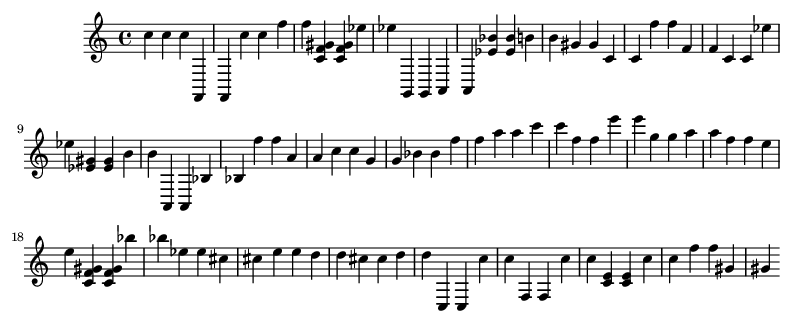

In [153]:
music = array_to_music(notes)
play(music)
show(music)